In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm

In [2]:
fileroot='../../Data/'
figureroot=fileroot+'Figures/'

In [3]:
cd4=pd.read_pickle(fileroot+'CD4_sequences.pkl')
cd8=pd.read_pickle(fileroot+'CD8_sequences.pkl')
vdjdb=pd.read_pickle(fileroot+'vdjdb.pkl')

In [4]:
vdjdb['Clonotype']=vdjdb.V+'_'+vdjdb.CDR3
cd4['Clonotype_alpha']=cd4.Va+'_'+cd4.CDR3a
cd8['Clonotype_alpha']=cd8.Va+'_'+cd8.CDR3a
cd4['Clonotype_beta']=cd4.Vb+'_'+cd4.CDR3b
cd8['Clonotype_beta']=cd8.Vb+'_'+cd8.CDR3b

In [5]:
a4=np.intersect1d(cd4.Clonotype_alpha,vdjdb[vdjdb['MHC class']=='MHCII'].Clonotype)
a8=np.intersect1d(cd8.Clonotype_alpha,vdjdb[vdjdb['MHC class']=='MHCI'].Clonotype)
b4=np.intersect1d(cd4.Clonotype_beta,vdjdb[vdjdb['MHC class']=='MHCII'].Clonotype)
b8=np.intersect1d(cd8.Clonotype_beta,vdjdb[vdjdb['MHC class']=='MHCI'].Clonotype)

In [6]:
feature4,counts4=np.unique(vdjdb[vdjdb.Clonotype.isin(a4)]['Epitope species'],return_counts=1)
feature8,counts8=np.unique(vdjdb[vdjdb.Clonotype.isin(a8)]['Epitope species'],return_counts=1)

In [7]:
def plot_singelchain(four,eight,cd4,cd8,figure):
    feature4,counts4=np.unique(vdjdb[vdjdb.Clonotype.isin(four)]['Epitope species'],return_counts=1)
    feature8,counts8=np.unique(vdjdb[vdjdb.Clonotype.isin(eight)]['Epitope species'],return_counts=1)
    features_all=np.unique(np.hstack((feature4,feature8)))
    data=pd.DataFrame(np.zeros((len(features_all),2)),columns=['Counts4','Counts8'],index=features_all)
    for x in features_all:
        if x in feature4:
            data['Counts4'].loc[x]=counts4[np.where(x==feature4)[0][0]]
        if x in feature8:
            data['Counts8'].loc[x]=counts8[np.where(x==feature8)[0][0]]
    order=data.index[np.array(np.argsort(data['Counts4']+data['Counts8']))[::-1]]
    fours=pd.DataFrame(np.vstack((data['Counts4'],['Four']*data['Counts4'].shape[0])).T,columns=['Counts','Chain'],index=data.index)
    eights=pd.DataFrame(np.vstack((data['Counts8'],['Eight']*data['Counts8'].shape[0])).T,columns=['Counts','Chain'],index=data.index)
    fours.Counts=(fours.Counts.astype(float)/np.unique(cd4).shape[0])*100
    eights.Counts=(eights.Counts.astype(float)/np.unique(cd8).shape[0])*100
    df=(fours.append(eights)).loc[order]
    df.index=['S.Cerevisiae' if x =='SaccharomycesCerevisiae' else x for x in df.index]
    df.index=['YellowFever' if x =='YellowFeverVirus' else x for x in df.index]
    df.index=['Human' if x =='HomoSapiens' else x for x in df.index]
    a4_dims = (8,6)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(df.index,df.Counts.astype(float),hue=df.Chain,palette=['Black','DarkGray',])
    plt.xticks(rotation=45,ha='right')
    plt.yscale('log')
    plt.ylabel('')
    plt.legend('')
    plt.ylim([.001,1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(figure+'.png',format='png', dpi=1200)
    plt.show()
    plt.close()

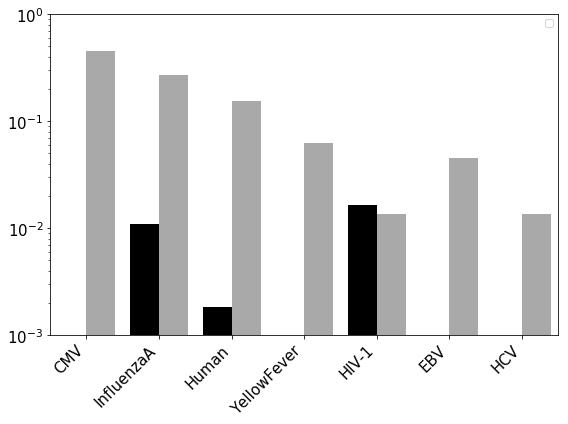

In [8]:
plot_singelchain(a4,a8,cd4.Clonotype_alpha,cd8.Clonotype_alpha,'Figure5_A')

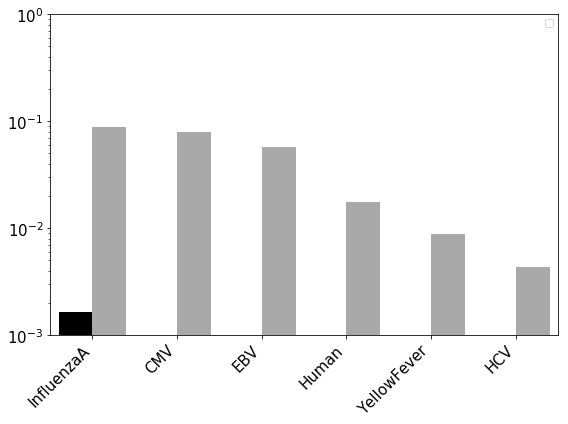

In [9]:
plot_singelchain(b4,b8,cd4.Clonotype_beta,cd8.Clonotype_beta,'Figure5_B')

In [10]:
four=cd4[(cd4.Clonotype_alpha.isin(vdjdb[vdjdb['MHC class']=='MHCII'].Clonotype)) & (cd4.Clonotype_beta.isin(vdjdb[vdjdb['MHC class']=='MHCII'].Clonotype))]
eight=cd8[(cd8.Clonotype_alpha.isin(vdjdb[vdjdb['MHC class']=='MHCI'].Clonotype)) & (cd8.Clonotype_beta.isin(vdjdb[vdjdb['MHC class']=='MHCI'].Clonotype))]

In [11]:
vdjdb.index=vdjdb.Clonotype

In [12]:
pairs=np.vstack((vdjdb.loc[eight.Clonotype_beta]['Epitope species'],vdjdb.loc[eight.Clonotype_alpha]['Epitope species'])).T

In [13]:
n=np.array(['InfluenzaA','CMV','EBV','HomoSapiens'])
data=pd.DataFrame(np.zeros((n.shape[0],n.shape[0])),columns=n,index=n)
for x,y in pairs:
    data[x].loc[y]+=1
data.index=['Human' if x=='HomoSapiens' else x for x in data.index]
data.columns=['Human' if x=='HomoSapiens' else x for x in data.index]

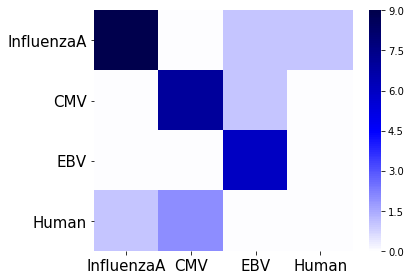

In [14]:
sns.heatmap(data,cmap='seismic_r',center=0)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('Figure5_C'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

In [15]:
df=pd.DataFrame(np.hstack((vdjdb.loc[eight.Clonotype_alpha][['Epitope species','Clonotype','Epitope gene']],vdjdb.loc[eight.Clonotype_beta][['Epitope species','Clonotype','Epitope gene']])))

In [16]:
df[1]=['('+x.split('_')[0]+') '+x.split('_')[1]  for x in df[1]]

In [17]:
df[4]=['('+x.split('_')[0]+') '+x.split('_')[1]  for x in df[4]]

In [18]:
pd.DataFrame(np.hstack((vdjdb.loc[four.Clonotype_alpha][['Epitope species','Clonotype','Epitope gene']],vdjdb.loc[four.Clonotype_beta][['Epitope species','Clonotype','Epitope gene']])))

,0,1,2,3,4,5
0,InfluenzaA,20_CAVQYGGSQGNLIF,HA,InfluenzaA,13_CASTRQNSNQPQHF,HA


In [19]:
df[6]=df[0]+' / '+df[3]
df[7]=df[2]+' / '+df[5]
df=df.drop(columns=[0,2,3,5])

In [20]:
df.sort_values(by=[6]).drop_duplicates()

,1,4,6,7
25,(26-2) CILSNNNDMRF,(30) CAWSVSDVANTEAFF,CMV / CMV,p65 / p65
24,(26-2) CILSNNNDMRF,(30) CAWSISDLAKNIQYF,CMV / CMV,p65 / p65
23,(3) CAVRGTNARLMF,(12-4) CASSSVTEAFF,CMV / CMV,p65 / p65
4,(17) CATGTGANNLFF,(5-1) CASSLDSQSSGNTIYF,CMV / CMV,p65 / IE1
5,(24) CAFPYNNNDMRF,(27) CASSLEGFTEAFF,CMV / CMV,p65 / p65
6,(24) CARNTGNQFYF,(5-1) CASSLDSQSSGNTIYF,CMV / CMV,p65 / IE1
17,(24) CAFPYNNNDMRF,(27) CASSLEGYTEAFF,CMV / CMV,p65 / p65
7,(24) CARNTGNQFYF,(20-1) CSARDRTGNGYTF,CMV / EBV,p65 / BMLF1
0,(20) CAVQDLGTSGSRLTF,(9) CASSARSGELFF,EBV / EBV,EBNA1 / EBNA1
12,(5) CAEDNNARLMF,(20-1) CSARDRTGNGYTF,EBV / EBV,BMLF1 / BMLF1
